In [1]:
import os

import nibabel as nib
import numpy as np
from nilearn.plotting import plot_roi, plot_img, plot_stat_map

from nimare.dataset import Dataset
from nimare.decode import discrete
from nimare.utils import get_resource_path

In [2]:
###### Load downloaded dataset #######
neuroquery_dset = Dataset.load(os.path.join('./neuroquery_data', "neuroquery_dataset.pkl.gz"))
print(neuroquery_dset)

Dataset(13459 experiments, space='mni152_2mm')


In [3]:
#### Specify the scope of cognitive terms ####
neuroquery_dset_copy = neuroquery_dset.copy()
neuroquery_dset_copy.annotations=neuroquery_dset_copy.annotations.iloc[:, [0,1,2,
                                                              71-1, 452-1, 478-1, 511-1, 1084-1, 1806-1, 1956-1, 1967-1, 2721-1, 2932-1, 3347-1, 
                                                              3509-1, 3557-1, 3777-1, 3964-1, 4674-1, 4850-1, 5259-1, 6143-1, 
                                                              6150-1, 6168-1, 6184-1, 6280-1]]

# display the selected cognitive terms
column_names = neuroquery_dset_copy.annotations.columns.tolist()
new_column_names = column_names[:3]
for i in range(3,len(column_names)):
    cleaned_term = column_names[i].split("__")[1]
    print(cleaned_term)
    new_column_names.append(cleaned_term)

# Replace column names
neuroquery_dset_copy.annotations.columns = new_column_names

action
attention
auditory
autobiographical
cognitive control
emotional
eye movement
face
inhibition
language
memory
motor
multisensory
numerical
pain
reading
reward
social cognition
visual
visual attention
visual perception
visuospatial
working memory


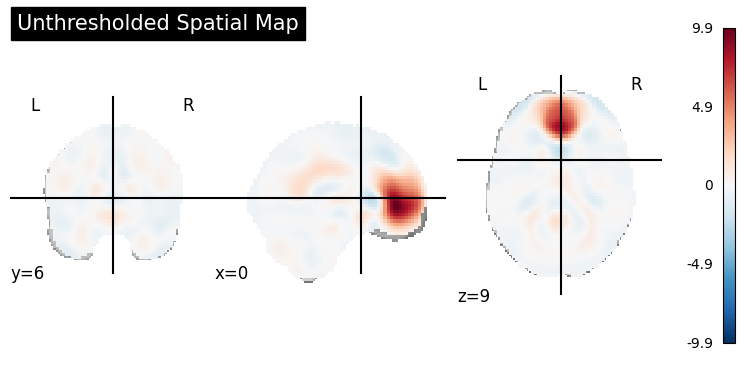

In [4]:
##### Load spatial maps ######
from nilearn import image

# NeuroMark for spatial maps
neuromark_file_path = "Neuromark_fMRI_2.2_modelorder-multi.nii"

# Load nifti images
neuromark_img = image.load_img(neuromark_file_path)

# Sensorimotor: 56, DMN (precuneus): 95, DMN (MPFC): 101
img_SM = image.index_img(neuromark_img, 101)
plot_stat_map(img_SM, title="Unthresholded Spatial Map")

/tmp/ipykernel_145790/1104305248.py:20: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  ICN_SM_thres = masking.unmask(z_thresh, mask_rs)


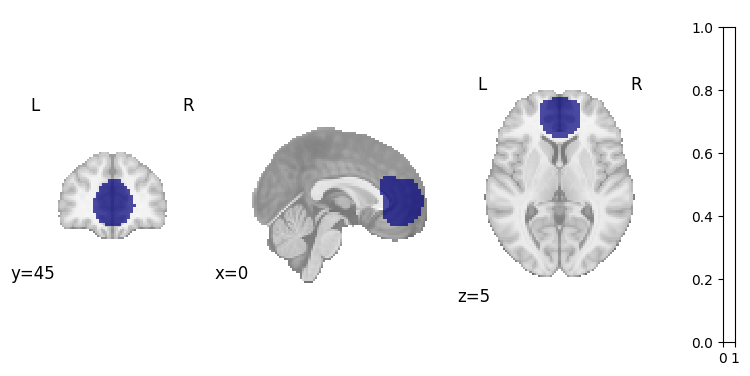

In [5]:
##### Threshold the spatial maps to specify the ROI for decoding #####
from nilearn import masking, datasets
from scipy.stats import zscore

# 1. Load Brain Mask
mask_img = datasets.load_mni152_brain_mask()
mask_rs = image.resample_to_img(mask_img, img_SM, interpolation="nearest",force_resample=True,copy_header=True)

# 2. Apply mask
masked_data = masking.apply_mask(img_SM, mask_rs)

# z-score
z_data = zscore(masked_data, axis=0, nan_policy='omit')

# threshold |z| > 3
threshold = 3
z_thresh = np.where(np.abs(z_data) >= threshold, 1, 0)

# Restore nifti format
ICN_SM_thres = masking.unmask(z_thresh, mask_rs)

plot_roi(ICN_SM_thres, draw_cross=False)


# Dummy mask for resampling
arr = np.zeros(neuroquery_dset.masker.mask_img.shape, np.int32)
mask_img_nimare = nib.Nifti1Image(arr, neuroquery_dset.masker.mask_img.affine)

# Resample the thresholded spatial map to be in the same space as the NeuroSynth dataset
ICN_SM_thres_mni152 = image.resample_to_img(ICN_SM_thres, mask_img_nimare, interpolation="nearest",force_resample=True,copy_header=True)

In [6]:
#### Training NeuroSynth Decoder ####

from nimare.decode import discrete

# Get studies with voxels in the mask
ids = neuroquery_dset_copy.get_studies_by_mask(ICN_SM_thres_mni152)

# Train the decoder
decoder = discrete.NeurosynthDecoder(correction=None)
decoder.fit(neuroquery_dset_copy)

In [7]:
#### Decode ####

decoded_df = decoder.transform(ids=ids)
decoded_df.sort_values(by="probReverse", ascending=False)

,pForward,zForward,probForward,pReverse,zReverse,probReverse
Term,,,,,,
autobiographical,NaN,NaN,0.499960,4.829034e-47,14.404773,0.625802
emotional,0.000000e+00,inf,0.400049,1.192973e-92,20.416506,0.608044
reward,9.894976e-01,-0.013163,0.435347,2.677134e-51,15.066814,0.589664
social cognition,NaN,NaN,0.447569,3.299004e-21,9.452795,0.578420
pain,0.000000e+00,-inf,0.421356,6.375812e-11,6.534651,0.549733
cognitive control,7.322371e-12,-6.851218,0.412854,3.366900e-14,7.583371,0.547715
inhibition,2.706134e-11,6.661735,0.398485,6.474637e-06,4.510266,0.526218
attention,0.000000e+00,inf,0.384278,5.011440e-05,4.055093,0.523276
memory,0.000000e+00,inf,0.387311,5.985336e-03,2.748584,0.515232


In [8]:
#### BrainMap Decoder ####

from nimare.decode import discrete

# Get studies with voxels in the mask
ids = neuroquery_dset_copy.get_studies_by_mask(ICN_SM_thres_mni152)

# Decode
decoder = discrete.BrainMapDecoder(correction=None)
decoder.fit(neuroquery_dset_copy)
decoded_df = decoder.transform(ids=ids)
decoded_df.sort_values(by="probReverse", ascending=False)

/home/users/ysong30/anaconda3/envs/fmri/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,pForward,zForward,likelihoodForward,pReverse,zReverse,probReverse
Term,,,,,,
visual,9.999991e-01,1.085907e-06,0.925231,1.455083e-09,-6.049265,0.111339
attention,2.639123e-01,1.117192e+00,1.010455,5.011440e-05,4.055093,0.108837
memory,8.653730e-01,1.695386e-01,0.980717,5.985336e-03,-2.748584,0.097479
emotional,0.000000e+00,inf,1.277609,1.192973e-92,20.416506,0.092955
motor,1.000000e+00,8.773144e-13,0.877888,8.760857e-10,-6.130490,0.082525
inhibition,1.470113e-06,4.815256e+00,1.123803,6.474637e-06,4.510266,0.053843
face,3.844536e-01,8.697197e-01,1.006746,2.858343e-01,1.067305,0.052698
action,8.807846e-01,1.499746e-01,0.971481,9.894885e-01,-0.013175,0.051150
working memory,9.999745e-01,3.195675e-05,0.907320,2.370494e-01,-1.182394,0.048764


In [9]:
#### ROI Assoicaiton Decoder (used in Margulias et al. 2016) ####

from nimare.decode import discrete

decoder = discrete.ROIAssociationDecoder(ICN_SM_thres_mni152)
decoder.fit(neuroquery_dset_copy)

# The `transform` method doesn't take any parameters.
decoded_df = decoder.transform()
decoded_df.sort_values(by="r", ascending=False)

,r
feature,
emotional,0.084986
autobiographical,0.082838
reward,0.081003
social cognition,0.050613
pain,0.022055
memory,0.007766
inhibition,-0.002799
cognitive control,-0.007828
face,-0.015775
